# Multiple Linear Regression
## Housing Case Study

#### Problem Statement:

Consider a real estate company that has a dataset containing the prices of properties in the Delhi region. It wishes to use the data to optimise the sale prices of the properties based on important factors such as area, bedrooms, parking, etc.

Essentially, the company wants —


- To identify the variables affecting house prices, e.g. area, number of rooms, bathrooms, etc.

- To create a linear model that quantitatively relates house prices with variables such as number of rooms, area, number of bathrooms, etc.

- To know the accuracy of the model, i.e. how well these variables can predict house prices.

**So interpretation is important!**

## Step 1: Reading and Understanding the Data

Let us first import NumPy and Pandas and read the housing dataset

In [1]:
# Supress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.api as sm

In [3]:
df_housing = pd.read_csv('../../Datasets/Housing.csv')

In [4]:
df_housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


Inspect the various aspects of the housing dataframe

In [5]:
df_housing.shape

(545, 13)

In [6]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [7]:
df_housing.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [8]:
# Numeric and Categorical Columns
num_cols = df_housing.select_dtypes(include=np.number).columns
print('\033[1m'+ 'Numerical Columns' + '\033[0m')
print(num_cols)

print()

cat_cols = df_housing.select_dtypes(exclude=np.number).columns
print('\033[1m'+ 'Categorical Columns' + '\033[0m')
print(cat_cols)

Numerical Columns
Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking'], dtype='object')

Categorical Columns
Index(['mainroad', 'guestroom', 'basement', 'hotwaterheating',
       'airconditioning', 'prefarea', 'furnishingstatus'],
      dtype='object')


## Step 2: Visualising the Data

Let's now spend some time doing what is arguably the most important step - **understanding the data**.
- If there is some obvious multicollinearity going on, this is the first place to catch it
- Here's where you'll also identify if some predictors directly have a strong association with the outcome variable

We'll visualise our data using `matplotlib` and `seaborn`.

#### Visualising Numeric Variables

Let's make a pairplot of all the numeric variables

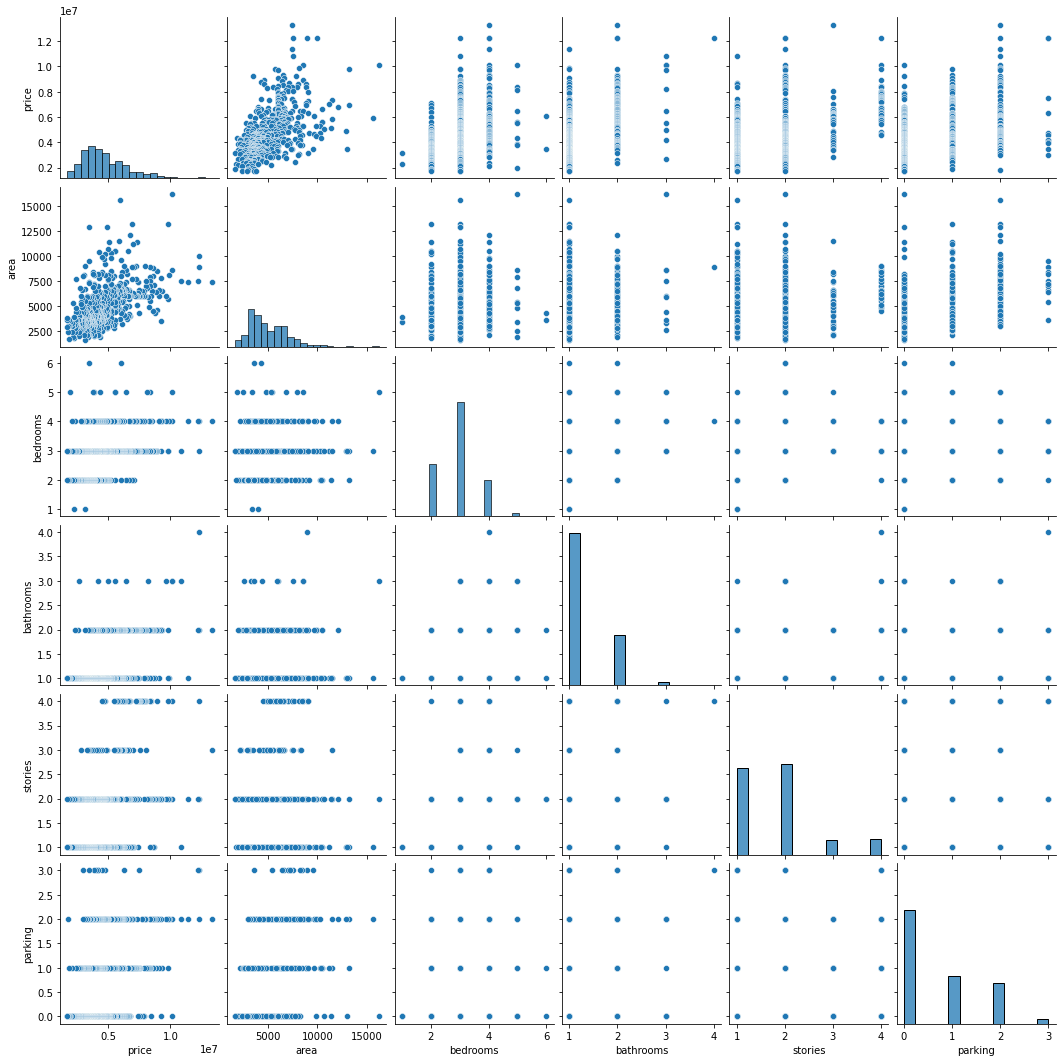

In [9]:
sns.pairplot(df_housing)
plt.show()

#### Visualising Categorical Variables

As you might have noticed, there are a few categorical variables as well. Let's make a boxplot for some of these variables.

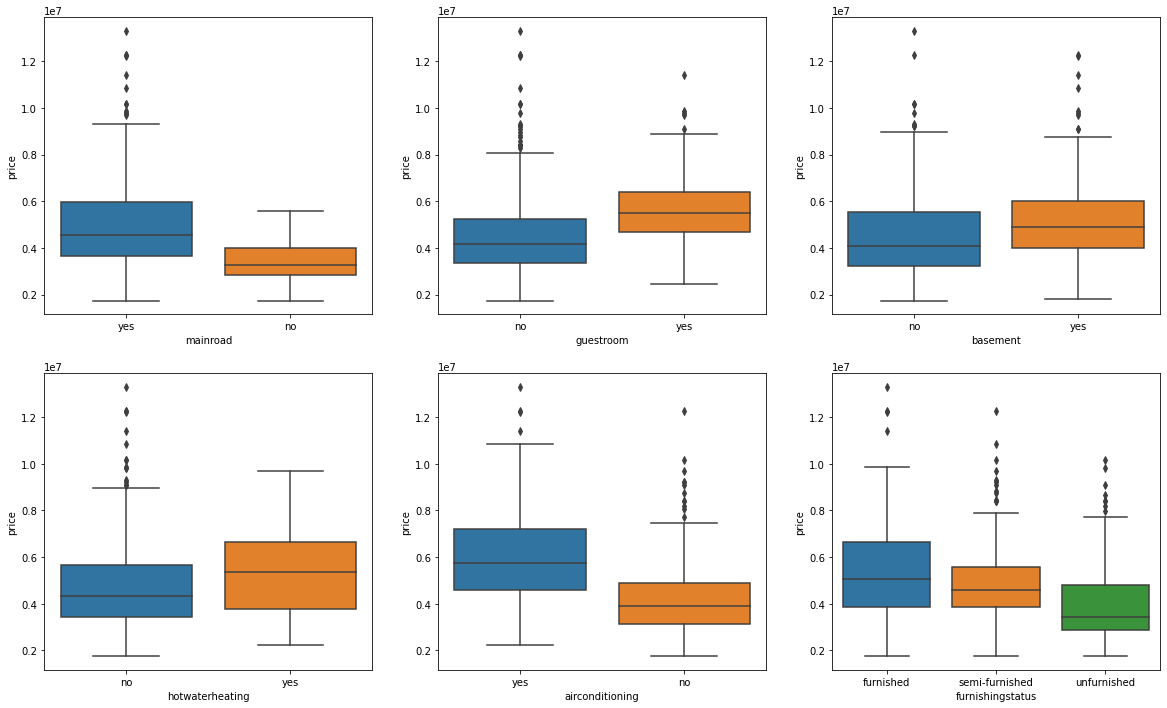

In [10]:
plt.figure(figsize=(20, 12))

plt.subplot(2,3,1)
sns.boxplot(x = 'mainroad', y = 'price', data = df_housing)

plt.subplot(2,3,2)
sns.boxplot(x = 'guestroom', y = 'price', data = df_housing)

plt.subplot(2,3,3)
sns.boxplot(x = 'basement', y = 'price', data = df_housing)

plt.subplot(2,3,4)
sns.boxplot(x = 'hotwaterheating', y = 'price', data = df_housing)

plt.subplot(2,3,5)
sns.boxplot(x = 'airconditioning', y = 'price', data = df_housing)

plt.subplot(2,3,6)
sns.boxplot(x = 'furnishingstatus', y = 'price', data = df_housing)
plt.show()

We can also visualise some of these categorical features parallely by using the `hue` argument. Below is the plot for `furnishingstatus` with `airconditioning` as the hue.

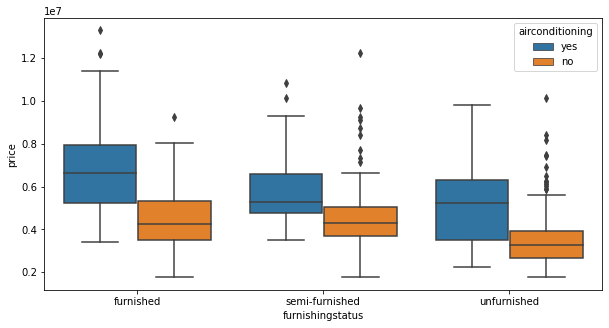

In [11]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'furnishingstatus', y = 'price', hue = 'airconditioning', data = df_housing)
plt.show()

## Step 3: Data Preparation

- You can see that your dataset has many columns with values as 'Yes' or 'No'.

- But in order to fit a regression line, we would need numerical values and not string. Hence, we need to convert them to 1s and 0s, where 1 is a 'Yes' and 0 is a 'No'.

In [12]:
# List of features to map

feats =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, 'no': 0})

# Applying the function to the housing list
df_housing[feats] = df_housing[feats].apply(binary_map)

In [13]:
df_housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


### Dummy Variables

The variable `furnishingstatus` has three levels. We need to convert these levels into integer as well. 

For this, we will use something called `dummy variables`.

Now, you don't need three columns. You can drop the `furnished` column, as the type of furnishing can be identified with just the last two columns where — 
- `00` will correspond to `furnished`
- `01` will correspond to `unfurnished`
- `10` will correspond to `semi-furnished`

In [14]:
# Get the dummy vars for the feature `furnishingstatus` and store it in a new variable and then contatenate it in the original df
status = pd.get_dummies(df_housing['furnishingstatus'], drop_first=True)

In [15]:
status.head()

,semi-furnished,unfurnished
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0


In [16]:
# Concatenate it to the original dataset
df_housing = pd.concat([df_housing, status], axis= 1).drop('furnishingstatus', axis=1)

df_housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


## Step 4: Splitting the Data into Training and Testing Sets

As you know, the first basic step for regression is performing a train-test split.

In [17]:
x = df_housing.iloc[:, 1:]
y = df_housing.iloc[:, 0]

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=100)

### Rescaling the Features 

As you saw in the demonstration for Simple Linear Regression, scaling doesn't impact your model. Here we can see that except for `area`, all the columns have small integer values. So it is extremely important to rescale the variables so that they have a comparable scale. If we don't have comparable scales, then some of the coefficients as obtained by fitting the regression model might be very large or very small as compared to the other coefficients. This might become very annoying at the time of model evaluation. So it is advised to use standardization or normalization so that the units of the coefficients obtained are all on the same scale. As you know, there are two common ways of rescaling:

1. Min-Max scaling 
2. Standardisation (mean-0, sigma-1) 

This time, we will use MinMax scaling.

In [19]:
scaler = MinMaxScaler()

In [22]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']

x_train[num_vars] = scaler.fit_transform(x_train[num_vars])

In [23]:
x_train.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
359,0.155227,0.4,0.0,0.000000,1,0,0,0,0,0.333333,0,0,1
19,0.403379,0.4,0.5,0.333333,1,0,0,0,1,0.333333,1,1,0
159,0.115628,0.4,0.5,0.000000,1,1,1,0,1,0.000000,0,0,0
35,0.454417,0.4,0.5,1.000000,1,0,0,0,1,0.666667,0,0,0
28,0.538015,0.8,0.5,0.333333,1,0,1,1,0,0.666667,0,0,1


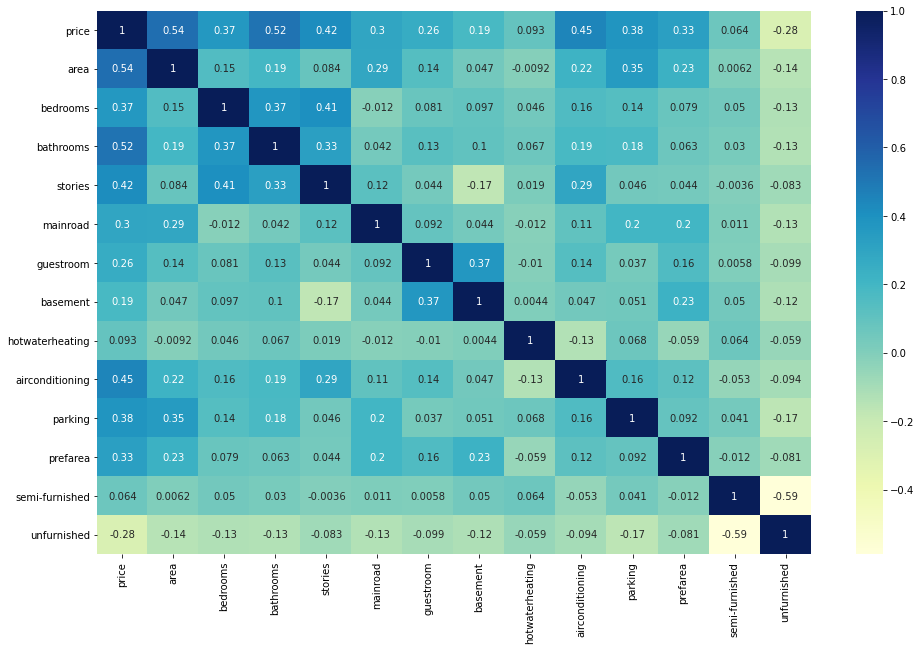

In [24]:
# Let's check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (16, 10))
sns.heatmap(df_housing.corr(), annot = True, cmap="YlGnBu")
plt.show()

As you might have noticed, `area` seems to the correlated to `price` the most. Let's see a pairplot for `area` vs `price`.

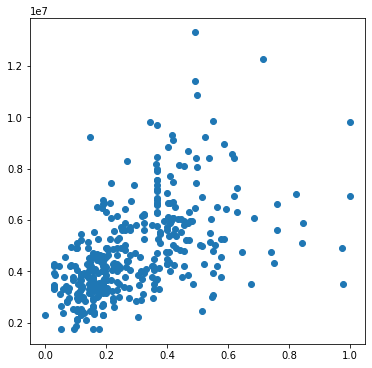

In [25]:
plt.figure(figsize=[6,6])
plt.scatter(x_train.area, y_train.ravel())
plt.show()

So, we pick `area` as the first variable and we'll try to fit a regression line to that.

## Step 5: Building a linear model

Fit a regression line through the training data using `statsmodels`. Remember that in `statsmodels`, you need to explicitly fit a constant using `sm.add_constant(X)` because if we don't perform this step, `statsmodels` fits a regression line passing through the origin, by default.

In [26]:
# Add a constant
x_train_lr = sm.add_constant(x_train[['area']])

# Create a first fitted model
lr = sm.OLS(y_train, x_train_lr).fit()

In [27]:
lr.params

const    3.215622e+06
area     5.338317e+06
dtype: float64

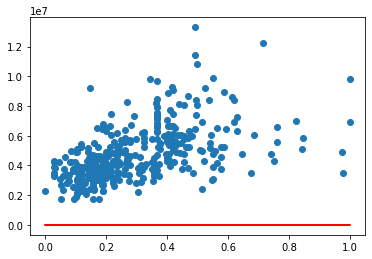

In [28]:
# Let's visualise the data with a scatter plot and the fitted regression line
plt.scatter(x_train_lr.iloc[:, 1], y_train)
plt.plot(x_train_lr.iloc[:, 1], 0.127 + 0.462*x_train_lr.iloc[:, 1], 'r')
plt.show()

In [29]:
# Print a summary of the linear regression model obtained
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     149.6
Date:                Sat, 17 Jul 2021   Prob (F-statistic):           3.15e-29
Time:                        18:46:24   Log-Likelihood:                -5968.7
No. Observations:                 381   AIC:                         1.194e+04
Df Residuals:                     379   BIC:                         1.195e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.216e+06   1.49e+05     21.617      0.0

### Adding another variable

The R-squared value obtained is `0.283`. Since we have so many variables, we can clearly do better than this. So let's go ahead and add the second most highly correlated variable, i.e. `bathrooms`.

In [30]:
# Add a constant
x_train_lr = sm.add_constant(x_train[['area', 'bathrooms']])

# Create a first fitted model
lr = sm.OLS(y_train, x_train_lr).fit()

In [31]:
lr.params

const        2.958006e+06
area         4.601474e+06
bathrooms    3.446220e+06
dtype: float64

In [32]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     174.1
Date:                Sat, 17 Jul 2021   Prob (F-statistic):           2.51e-54
Time:                        18:46:32   Log-Likelihood:                -5907.7
No. Observations:                 381   AIC:                         1.182e+04
Df Residuals:                     378   BIC:                         1.183e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.958e+06   1.29e+05     22.979      0.000     2.7e+06    3.21e+06
area        4.601e+06   3.77e+05     12.192      0.000    3.86e+06    5.34e+06
bathrooms   3.446e+06   2.89e+05     11.945      0.000    2.88e+06    4.01e+06
==============================================================================
Omnibus:                       62.839   Durbin-Watson:                   2.157
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.790
Skew:                           0.784   Prob(JB):                     2.23e-37
Kurtosis:                       5.859   Cond. No.                         6.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We have clearly improved the model as the value of adjusted R-squared as its value has gone up to `0.477` from `0.281`.
Let's go ahead and add another variable, `airconditioning`.

In [33]:
# Add a constant
x_train_lr = sm.add_constant(x_train[['area', 'bathrooms', 'airconditioning']])

# Create a first fitted model
lr = sm.OLS(y_train, x_train_lr).fit()

In [34]:
lr.params

const              2.844435e+06
area               4.135600e+06
bathrooms          3.061256e+06
airconditioning    1.004684e+06
dtype: float64

In [35]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     146.4
Date:                Sat, 17 Jul 2021   Prob (F-statistic):           6.61e-63
Time:                        18:46:40   Log-Likelihood:                -5884.9
No. Observations:                 381   AIC:                         1.178e+04
Df Residuals:                     377   BIC:                         1.179e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.844e+06   1.23e+05     23.214      0.000     2.6e+06    3.09e+06
area             4.136e+06   3.62e+05     11.414      0.000    3.42e+06    4.85e+06
bathrooms        3.061e+06   2.78e+05     11.021      0.000    2.52e+06    3.61e+06
airconditioning  1.005e+06   1.45e+05      6.916      0.000    7.19e+05    1.29e+06
==============================================================================
Omnibus:                       67.166   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.372
Skew:                           0.863   Prob(JB):                     4.52e-37
Kurtosis:                       5.750   Cond. No.                         6.55
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We have improved the adjusted R-squared again. Now let's go ahead and add all the feature variables.

### Adding all the variables to the model

In [36]:
# Check all the columns of the dataframe

df_housing.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'semi-furnished', 'unfurnished'],
      dtype='object')

In [37]:
x_train_lr = sm.add_constant(x_train)

lr_1 = sm.OLS(y_train, x_train_lr).fit()

lr_1.params

const              1.981379e+06
area               2.710364e+06
bedrooms           5.397838e+05
bathrooms          2.204008e+06
stories            1.253356e+06
mainroad           5.825986e+05
guestroom          3.514464e+05
basement           2.494209e+05
hotwaterheating    9.801708e+05
airconditioning    7.724748e+05
parking            7.014931e+05
prefarea           6.863920e+05
semi-furnished     1.063202e+04
unfurnished       -3.581148e+05
dtype: float64

In [38]:
lr_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     60.40
Date:                Sat, 17 Jul 2021   Prob (F-statistic):           8.83e-83
Time:                        18:46:51   Log-Likelihood:                -5814.1
No. Observations:                 381   AIC:                         1.166e+04
Df Residuals:                     367   BIC:                         1.171e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.981e+06   2.42e+05      8.176      0.000     1.5e+06    2.46e+06
area              2.71e+06   3.48e+05      7.795      0.000    2.03e+06    3.39e+06
bedrooms         5.398e+05   4.26e+05      1.267      0.206   -2.98e+05    1.38e+06
bathrooms        2.204e+06   2.54e+05      8.679      0.000     1.7e+06     2.7e+06
stories          1.253e+06   2.21e+05      5.661      0.000    8.18e+05    1.69e+06
mainroad         5.826e+05   1.65e+05      3.520      0.000    2.57e+05    9.08e+05
guestroom        3.514e+05   1.57e+05      2.233      0.026     4.2e+04    6.61e+05
basement         2.494e+05   1.28e+05      1.943      0.053   -3043.974    5.02e+05
hotwaterheating  9.802e+05   2.49e+05      3.934      0.000     4.9e+05    1.47e+06
airconditioning  7.725e+05   1.31e+05      5.899      0.000    5.15e+05    1.03e+06
parking          7.015e+05   2.08e+05      3.365      0.001    2.92e+05    1.11e+06
prefarea         6.864e+05   1.36e+05      5.040      0.000    4.19e+05    9.54e+05
semi-furnished   1.063e+04   1.36e+05      0.078      0.938   -2.58e+05    2.79e+05
unfurnished     -3.581e+05   1.47e+05     -2.440      0.015   -6.47e+05   -6.95e+04
==============================================================================
Omnibus:                       93.687   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              304.917
Skew:                           1.091   Prob(JB):                     6.14e-67
Kurtosis:                       6.801   Cond. No.                         14.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Looking at the p-values, it looks like some of the variables aren't really significant (in the presence of other variables).

Maybe we could drop some?

We could simply drop the variable with the highest, non-significant p value. A better way would be to supplement this with the VIF information. 

### Checking VIF

Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. The formula for calculating `VIF` is:

### $ VIF_i = \frac{1}{1 - {R_i}^2} $

In [39]:
vif = pd.DataFrame()
vif['Features'] = x_train.columns
vif['VIF'] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
1,bedrooms,7.33
4,mainroad,6.02
0,area,4.67
3,stories,2.70
11,semi-furnished,2.19
9,parking,2.12
6,basement,2.02
12,unfurnished,1.82
8,airconditioning,1.77
2,bathrooms,1.67


We generally want a VIF that is less than 5. So there are clearly some variables we need to drop.

### Dropping the variable and updating the model

As you can see from the summary and the VIF dataframe, some variables are still insignificant. One of these variables is, `semi-furnished` as it has a very high p-value of `0.938`. Let's go ahead and drop this variables

In [40]:
x_train_new = x_train.drop('semi-furnished', axis=1)

In [41]:
# Build a third fitted model
x_train_lr = sm.add_constant(x_train_new)

lr_2 = sm.OLS(y_train, x_train_lr).fit()

In [42]:
lr_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     65.61
Date:                Sat, 17 Jul 2021   Prob (F-statistic):           1.07e-83
Time:                        18:47:05   Log-Likelihood:                -5814.1
No. Observations:                 381   AIC:                         1.165e+04
Df Residuals:                     368   BIC:                         1.171e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             1.99e+06   2.18e+05      9.117      0.000    1.56e+06    2.42e+06
area             2.707e+06   3.45e+05      7.845      0.000    2.03e+06    3.39e+06
bedrooms         5.395e+05   4.26e+05      1.268      0.206   -2.97e+05    1.38e+06
bathrooms        2.205e+06   2.53e+05      8.697      0.000    1.71e+06     2.7e+06
stories          1.253e+06   2.21e+05      5.669      0.000    8.18e+05    1.69e+06
mainroad         5.821e+05   1.65e+05      3.524      0.000    2.57e+05    9.07e+05
guestroom        3.517e+05   1.57e+05      2.238      0.026    4.27e+04    6.61e+05
basement         2.495e+05   1.28e+05      1.946      0.052   -2568.953    5.02e+05
hotwaterheating  9.805e+05   2.49e+05      3.941      0.000    4.91e+05    1.47e+06
airconditioning  7.716e+05    1.3e+05      5.923      0.000    5.15e+05    1.03e+06
parking          7.018e+05   2.08e+05      3.372      0.001    2.92e+05    1.11e+06
prefarea         6.863e+05   1.36e+05      5.046      0.000    4.19e+05    9.54e+05
unfurnished     -3.649e+05   1.18e+05     -3.096      0.002   -5.97e+05   -1.33e+05
==============================================================================
Omnibus:                       93.538   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              303.844
Skew:                           1.090   Prob(JB):                     1.05e-66
Kurtosis:                       6.794   Cond. No.                         14.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
vif = pd.DataFrame()
vif['Features'] = x_train_new.columns
vif['VIF'] = [variance_inflation_factor(x_train_new.values, i) for i in range(x_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
1,bedrooms,6.59
4,mainroad,5.68
0,area,4.67
3,stories,2.69
9,parking,2.12
6,basement,2.01
8,airconditioning,1.77
2,bathrooms,1.67
10,prefarea,1.51
5,guestroom,1.47


### Dropping the Variable and Updating the Model

As you can notice some of the variable have high VIF values as well as high p-values. Such variables are insignificant and should be dropped.

As you might have noticed, the variable `bedroom` has a significantly high VIF (`6.6`) and a high p-value (`0.206`) as well. Hence, this variable isn't of much use and should be dropped.

In [44]:
x_train_new = x_train_new.drop('bedrooms', axis=1)

In [45]:
# Build a third fitted model
x_train_lr = sm.add_constant(x_train_new)

lr_3 = sm.OLS(y_train, x_train_lr).fit()

In [46]:
lr_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     71.31
Date:                Sat, 17 Jul 2021   Prob (F-statistic):           2.73e-84
Time:                        18:47:07   Log-Likelihood:                -5814.9
No. Observations:                 381   AIC:                         1.165e+04
Df Residuals:                     369   BIC:                         1.170e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.163e+06    1.7e+05     12.691      0.000    1.83e+06     2.5e+06
area             2.711e+06   3.45e+05      7.851      0.000    2.03e+06    3.39e+06
bathrooms        2.269e+06   2.48e+05      9.132      0.000    1.78e+06    2.76e+06
stories           1.36e+06   2.04e+05      6.654      0.000    9.58e+05    1.76e+06
mainroad         5.636e+05   1.65e+05      3.423      0.001     2.4e+05    8.87e+05
guestroom        3.476e+05   1.57e+05      2.211      0.028    3.85e+04    6.57e+05
basement         2.762e+05   1.27e+05      2.183      0.030    2.74e+04    5.25e+05
hotwaterheating   9.98e+05   2.49e+05      4.014      0.000    5.09e+05    1.49e+06
airconditioning  7.685e+05    1.3e+05      5.895      0.000    5.12e+05    1.02e+06
parking          7.262e+05   2.07e+05      3.501      0.001    3.18e+05    1.13e+06
prefarea         6.889e+05   1.36e+05      5.061      0.000    4.21e+05    9.57e+05
unfurnished     -3.733e+05   1.18e+05     -3.169      0.002   -6.05e+05   -1.42e+05
==============================================================================
Omnibus:                       97.661   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              325.388
Skew:                           1.130   Prob(JB):                     2.20e-71
Kurtosis:                       6.923   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
vif = pd.DataFrame()
vif['Features'] = x_train_new.columns
vif['VIF'] = [variance_inflation_factor(x_train_new.values, i) for i in range(x_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
3,mainroad,4.79
0,area,4.55
2,stories,2.23
8,parking,2.10
5,basement,1.87
7,airconditioning,1.76
1,bathrooms,1.61
9,prefarea,1.50
4,guestroom,1.46
10,unfurnished,1.33


### Dropping the variable and updating the model

As you might have noticed, dropping `semi-furnised` decreased the VIF of `mainroad` as well such that it is now under 5. But from the summary, we can still see some of them have a high p-value. `basement` for instance, has a p-value of 0.03. We should drop this variable as well.

In [48]:
x_train_new.drop('basement', axis=1, inplace=True)

In [49]:
# Build a third fitted model
x_train_lr = sm.add_constant(x_train_new)

lr_4 = sm.OLS(y_train, x_train_lr).fit()

In [50]:
lr_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     77.18
Date:                Sat, 17 Jul 2021   Prob (F-statistic):           3.13e-84
Time:                        18:47:10   Log-Likelihood:                -5817.4
No. Observations:                 381   AIC:                         1.166e+04
Df Residuals:                     370   BIC:                         1.170e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.244e+06   1.67e+05     13.432      0.000    1.92e+06    2.57e+06
area             2.697e+06   3.47e+05      7.772      0.000    2.01e+06    3.38e+06
bathrooms        2.331e+06   2.48e+05      9.397      0.000    1.84e+06    2.82e+06
stories          1.249e+06   1.99e+05      6.277      0.000    8.58e+05    1.64e+06
mainroad         5.737e+05   1.65e+05      3.468      0.001    2.48e+05    8.99e+05
guestroom        4.643e+05   1.49e+05      3.124      0.002    1.72e+05    7.56e+05
hotwaterheating  1.012e+06    2.5e+05      4.051      0.000    5.21e+05     1.5e+06
airconditioning   7.88e+05   1.31e+05      6.028      0.000    5.31e+05    1.04e+06
parking           7.26e+05   2.08e+05      3.482      0.001    3.16e+05    1.14e+06
prefarea         7.363e+05   1.35e+05      5.452      0.000    4.71e+05       1e+06
unfurnished     -3.892e+05   1.18e+05     -3.295      0.001   -6.22e+05   -1.57e+05
==============================================================================
Omnibus:                       97.054   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              322.034
Skew:                           1.124   Prob(JB):                     1.18e-70
Kurtosis:                       6.902   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
vif = pd.DataFrame()
vif['Features'] = x_train_new.columns
vif['VIF'] = [variance_inflation_factor(x_train_new.values, i) for i in range(x_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
3,mainroad,4.55
0,area,4.54
2,stories,2.12
7,parking,2.10
6,airconditioning,1.75
1,bathrooms,1.58
8,prefarea,1.47
9,unfurnished,1.33
4,guestroom,1.30
5,hotwaterheating,1.12


Now as you can see, the VIFs and p-values both are within an acceptable range. So we go ahead and make our predictions using this model only.

## Step 7: Residual Analysis of the train data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [52]:
y_train_pred = lr_4.predict(x_train_lr)

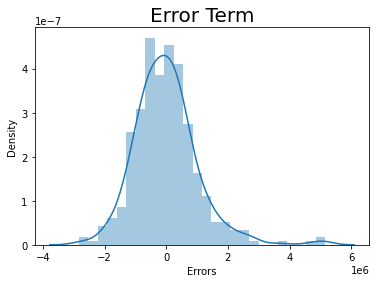

In [53]:
sns.distplot(y_train.ravel() - y_train_pred)
plt.title("Error Term", fontsize=20)
plt.xlabel('Errors')
plt.show()

## Step 8: Making Predictions Using the Final Model

Now that we have fitted the model and checked the normality of error terms, it's time to go ahead and make predictions using the final, i.e. fourth model.

#### Applying the scaling on the test sets

In [54]:
num_vars = x_train.select_dtypes(include=['float64']).columns

x_test[num_vars] = scaler.transform(x_test[num_vars])

In [55]:
x_test.describe()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,0.298548,0.408537,0.158537,0.268293,0.865854,0.195122,0.347561,0.030488,0.353659,0.205285,0.237805,0.420732,0.329268
std,0.211922,0.147537,0.281081,0.276007,0.341853,0.397508,0.477654,0.172452,0.479569,0.289322,0.427043,0.495189,0.471387
min,-0.016367,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.148011,0.400000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.259724,0.400000,0.000000,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.397439,0.400000,0.500000,0.333333,1.000000,0.000000,1.000000,0.000000,1.000000,0.333333,0.000000,1.000000,1.000000
max,1.263992,0.800000,1.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [59]:
x_test_new = x_test[x_train_new.columns]

In [60]:
# Adding constant variable to test dataframe
x_test_new = sm.add_constant(x_test_new)

y_test_pred = lr_4.predict(x_test_new)

## Step 9: Model Evaluation

Let's now plot the graph for actual versus predicted values.

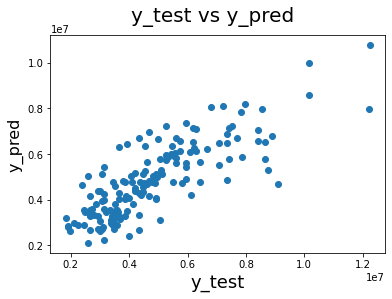

In [62]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)   
plt.show()


We can see that the equation of our best fitted line is:

$ price = 0.236  \times  area + 0.202  \times  bathrooms + 0.11 \times stories + 0.05 \times mainroad + 0.04 \times guestroom + 0.0876 \times hotwaterheating + 0.0682 \times airconditioning + 0.0629 \times parking + 0.0637 \times prefarea - 0.0337 \times unfurnished $


Overall we have a decent model, but we also acknowledge that we could do better. 

We have a couple of options:
1. Add new features (bathrooms/bedrooms, area/stories, etc.)
2. Build a non-linear model